In [1]:
!conda install -y gdown

Retrieving notices: ...working... done
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [2]:
!gdown https://github.com/shibhansh/loss-of-plasticity/archive/refs/heads/main.zip

Downloading...
From: https://github.com/shibhansh/loss-of-plasticity/archive/refs/heads/main.zip
To: /kaggle/working/main.zip
11.0MB [00:01, 5.85MB/s]


In [3]:
!echo "A" | unzip /kaggle/working/main.zip -d /kaggle/working/
!mkdir /kaggle/working/lop
!mkdir /kaggle/working/data/
!mv /kaggle/working/loss-of-plasticity-main/* /kaggle/working/lop/

Archive:  /kaggle/working/main.zip
646307016f9ea083cc7e88ee623d014ab04a9fca
   creating: /kaggle/working/loss-of-plasticity-main/
  inflating: /kaggle/working/loss-of-plasticity-main/.gitignore  
  inflating: /kaggle/working/loss-of-plasticity-main/README.md  
   creating: /kaggle/working/loss-of-plasticity-main/lop/
   creating: /kaggle/working/loss-of-plasticity-main/lop/algos/
  inflating: /kaggle/working/loss-of-plasticity-main/lop/algos/bp.py  
  inflating: /kaggle/working/loss-of-plasticity-main/lop/algos/cbp.py  
  inflating: /kaggle/working/loss-of-plasticity-main/lop/algos/convCBP.py  
  inflating: /kaggle/working/loss-of-plasticity-main/lop/algos/convGnT.py  
  inflating: /kaggle/working/loss-of-plasticity-main/lop/algos/gnt.py  
   creating: /kaggle/working/loss-of-plasticity-main/lop/imagenet/
  inflating: /kaggle/working/loss-of-plasticity-main/lop/imagenet/README.md  
  inflating: /kaggle/working/loss-of-plasticity-main/lop/imagenet/all_methods_imagenet.png  
  inflating:

In [4]:
import sys
import json
import torch
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
from tqdm import tqdm
from torch.nn.functional import softmax
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
sys.path.append('/kaggle/working/lop/')
sys.path.append('/kaggle/input')

In [6]:
from lop.algos.bp import Backprop
from lop.nets.conv_net import ConvNet
from lop.algos.convCBP import ConvCBP
from lop.nets.linear import MyLinear
from lop.utils.miscellaneous import nll_accuracy as accuracy

In [7]:
import os
import copy
import subprocess
import itertools

In [8]:
import torch
import pickle
import torchvision
import torchvision.transforms as transforms

def mnist():
    batch_size = 60000
    transform = transforms.Compose(
        [transforms.ToTensor()])

    train_dataset = torchvision.datasets.MNIST(
        root="data", train=True, transform=transform, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root="data", train=False, transform=transform
    )
    # Data loader
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cpu')

    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cpu')
    )

    for i, (images, labels) in enumerate(train_loader):
        images = images.flatten(start_dim=1)
        labels = labels

    x = images
    y = labels

    for i, (images_test, labels_test) in enumerate(test_loader):
        images_test = images_test.flatten(start_dim=1)
        labels_test = labels_test

    x_test = images_test
    y_test = labels_test

    with open('data/mnist_', 'wb+') as f:
        pickle.dump([x, y, x_test, y_test], f)

    return x, y, x_test, y_test


def get_mnist(type='reg'):
    if type == 'reg':
        data_file = 'data/mnist_'
        with open(data_file, 'rb+') as f:
            x, y, x_test, y_test = pickle.load(f)
    return x, y, x_test, y_test


In [9]:
mnist()

100%|██████████| 9912422/9912422 [00:00<00:00, 361144796.34it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49362548.42it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 218063736.30it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20506489.52it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([8, 5, 4,  ..., 5, 2, 8]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([7, 2, 1,  ..., 4, 5, 6]))

In [10]:
from lop.utils.miscellaneous import get_configurations

def gen_cfg(cfg_file):

    with open(cfg_file, 'r') as f:
        params = json.load(f)

    list_params, hyper_param_settings = get_configurations(params=params)

    # make a directory for temp cfg files
    bash_command = "mkdir -p temp_cfg/"
    subprocess.Popen(bash_command.split(), stdout=subprocess.PIPE)

    bash_command = "rm -r --force " + params['data_dir']
    subprocess.Popen(bash_command.split(), stdout=subprocess.PIPE)
    bash_command = "mkdir " + params['data_dir']
    subprocess.Popen(bash_command.split(), stdout=subprocess.PIPE)

    """
        Set and write all the parameters for the individual config files
    """
    for setting_index, param_setting in enumerate(hyper_param_settings):
        new_params = copy.deepcopy(params)
        for idx, param in enumerate(list_params):
            new_params[param] = param_setting[idx]
        new_params['index'] = setting_index
        new_params['data_dir'] = params['data_dir'] + str(setting_index) + '/'

        """
            Make the data directory
        """
        bash_command = "mkdir -p " + new_params['data_dir']
        subprocess.Popen(bash_command.split(), stdout=subprocess.PIPE)

        for idx in tqdm(range(params['num_runs'])):
            new_params['data_file'] = new_params['data_dir'] + str(idx)

            """
                write data in config files
            """
            new_cfg_file = 'temp_cfg/'+str(setting_index*params['num_runs']+idx)+'.json'
            try:    f = open(new_cfg_file, 'w+')
            except: f = open(new_cfg_file, 'w+')
            with open(new_cfg_file, 'w+') as f:
                json.dump(new_params, f, sort_keys=False, indent=4)

In [11]:
gen_cfg('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/std_net.json')

mkdir: cannot create directory ‘data/bp/std_net/’: No such file or directory
100%|██████████| 10/10 [00:00<00:00, 3997.24it/s]


In [12]:
from lop.algos.bp import Backprop
from lop.algos.cbp import ContinualBackprop
from lop.nets.linear import MyLinear
from torch.nn.functional import softmax
from lop.nets.deep_ffnn import DeepFFNN
from lop.utils.miscellaneous import nll_accuracy, compute_matrix_rank_summaries


def online_expr(params: {}):
    agent_type = params['agent']
    num_tasks = 60
#     if 'num_tasks' in params.keys():
#         num_tasks = params['num_tasks']
#     if 'num_examples' in params.keys() and "change_after" in params.keys():
#         num_tasks = int(params["num_examples"]/params["change_after"])

    step_size = params['step_size']
    opt = params['opt']
    weight_decay = 0
    use_gpu = 0
    dev = 'cpu'
    to_log = False
    num_features = 2000
    change_after = 10 * 6000
    to_perturb = False
    perturb_scale = 0.1
    num_hidden_layers = 1
    mini_batch_size = 1
    replacement_rate = 0.0001
    decay_rate = 0.99
    maturity_threshold = 100
    util_type = 'adaptable_contribution'

    if 'to_log' in params.keys():
        to_log = params['to_log']
    if 'weight_decay' in params.keys():
        weight_decay = params['weight_decay']
    if 'num_features' in params.keys():
        num_features = params['num_features']
    if 'change_after' in params.keys():
        change_after = params['change_after']
    if 'use_gpu' in params.keys():
        if params['use_gpu'] == 1:
            use_gpu = 1
            dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
            if dev == torch.device("cuda"):    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if 'to_perturb' in params.keys():
        to_perturb = params['to_perturb']
    if 'perturb_scale' in params.keys():
        perturb_scale = params['perturb_scale']
    if 'num_hidden_layers' in params.keys():
        num_hidden_layers = params['num_hidden_layers']
    if 'mini_batch_size' in params.keys():
        mini_batch_size = params['mini_batch_size']
    if 'replacement_rate' in params.keys():
        replacement_rate = params['replacement_rate']
    if 'decay_rate' in params.keys():
        decay_rate = params['decay_rate']
    if 'maturity_threshold' in params.keys():
        maturity_threshold = params['mt']
    if 'util_type' in params.keys():
        util_type = params['util_type']

    classes_per_task = 10
    images_per_class = 6000
    input_size = 784
    num_hidden_layers = num_hidden_layers
    net = DeepFFNN(input_size=input_size, num_features=num_features, num_outputs=classes_per_task,
                   num_hidden_layers=num_hidden_layers)

    if agent_type == 'linear':
        net = MyLinear(
            input_size=input_size, num_outputs=classes_per_task
        )
        net.layers_to_log = []

    if agent_type in ['bp', 'linear', "l2"]:
        learner = Backprop(
            net=net,
            step_size=step_size,
            opt=opt,
            loss='nll',
            weight_decay=weight_decay,
            device=dev,
            to_perturb=to_perturb,
            perturb_scale=perturb_scale,
        )
    elif agent_type in ['cbp']:
        learner = ContinualBackprop(
            net=net,
            step_size=step_size,
            opt=opt,
            loss='nll',
            replacement_rate=replacement_rate,
            maturity_threshold=maturity_threshold,
            decay_rate=decay_rate,
            util_type=util_type,
            accumulate=True,
            device=dev,
        )

    accuracy = nll_accuracy
    examples_per_task = images_per_class * classes_per_task
    total_examples = int(num_tasks * change_after)
    total_iters = int(total_examples/mini_batch_size)
    save_after_every_n_tasks = 1
    if num_tasks >= 10:
        save_after_every_n_tasks = int(num_tasks/10)

    accuracies = torch.zeros(total_iters, dtype=torch.float)
    weight_mag_sum = torch.zeros((total_iters, num_hidden_layers+1), dtype=torch.float)

    rank_measure_period = 60000
    effective_ranks = torch.zeros((int(total_examples/rank_measure_period), num_hidden_layers), dtype=torch.float)
    approximate_ranks = torch.zeros((int(total_examples/rank_measure_period), num_hidden_layers), dtype=torch.float)
    approximate_ranks_abs = torch.zeros((int(total_examples/rank_measure_period), num_hidden_layers), dtype=torch.float)
    ranks = torch.zeros((int(total_examples/rank_measure_period), num_hidden_layers), dtype=torch.float)
    dead_neurons = torch.zeros((int(total_examples/rank_measure_period), num_hidden_layers), dtype=torch.float)

    iter = 0
    with open('data/mnist_', 'rb+') as f:
        x, y, _, _ = pickle.load(f)
        if use_gpu == 1:
            x = x.to(dev)
            y = y.to(dev)

    for task_idx in (range(num_tasks)):
        new_iter_start = iter
        pixel_permutation = np.random.permutation(input_size)
        x = x[:, pixel_permutation]
        data_permutation = np.random.permutation(examples_per_task)
        x, y = x[data_permutation], y[data_permutation]

        if agent_type != 'linear':
            with torch.no_grad():
                new_idx = int(iter / rank_measure_period)
                m = net.predict(x[:2000])[1]
                for rep_layer_idx in range(num_hidden_layers):
                    ranks[new_idx][rep_layer_idx], effective_ranks[new_idx][rep_layer_idx], \
                    approximate_ranks[new_idx][rep_layer_idx], approximate_ranks_abs[new_idx][rep_layer_idx] = \
                        compute_matrix_rank_summaries(m=m[rep_layer_idx], use_scipy=True)
                    dead_neurons[new_idx][rep_layer_idx] = (m[rep_layer_idx].abs().sum(dim=0) == 0).sum()
                print('approximate rank: ', approximate_ranks[new_idx], ', dead neurons: ', dead_neurons[new_idx])

        for start_idx in tqdm(range(0, change_after, mini_batch_size)):
            start_idx = start_idx % examples_per_task
            batch_x = x[start_idx: start_idx+mini_batch_size]
            batch_y = y[start_idx: start_idx+mini_batch_size]

            # train the network
            loss, network_output = learner.learn(x=batch_x, target=batch_y)

            if to_log and agent_type != 'linear':
                for idx, layer_idx in enumerate(learner.net.layers_to_log):
                    weight_mag_sum[iter][idx] = learner.net.layers[layer_idx].weight.data.abs().sum()
            # log accuracy
            with torch.no_grad():
                accuracies[iter] = accuracy(softmax(network_output, dim=1), batch_y).cpu()
            iter += 1

        print('recent accuracy', accuracies[new_iter_start:iter - 1].mean())
        if task_idx % save_after_every_n_tasks == 0:
            data = {
                'accuracies': accuracies.cpu(),
                'weight_mag_sum': weight_mag_sum.cpu(),
                'ranks': ranks.cpu(),
                'effective_ranks': effective_ranks.cpu(),
                'approximate_ranks': approximate_ranks.cpu(),
                'abs_approximate_ranks': approximate_ranks_abs.cpu(),
                'dead_neurons': dead_neurons.cpu(),
            }
            save_data(file=params['data_file'], data=data)

    data = {
        'accuracies': accuracies.cpu(),
        'weight_mag_sum': weight_mag_sum.cpu(),
        'ranks': ranks.cpu(),
        'effective_ranks': effective_ranks.cpu(),
        'approximate_ranks': approximate_ranks.cpu(),
        'abs_approximate_ranks': approximate_ranks_abs.cpu(),
        'dead_neurons': dead_neurons.cpu(),
    }
    save_data(file=params['data_file'], data=data)


def save_data(file, data):
    with open(file, 'wb+') as f:
        pickle.dump(data, f)

In [13]:
!mkdir data/bp/std_net
!mkdir data/bp/std_net/0

mkdir: cannot create directory ‘data/bp/std_net’: File exists
mkdir: cannot create directory ‘data/bp/std_net/0’: File exists


In [14]:
with open(f'temp_cfg/0.json', 'r') as f:
    params = json.load(f)
    online_expr(params)

approximate rank:  tensor([692., 711., 660.]) , dead neurons:  tensor([ 0.,  5., 22.])


100%|██████████| 60000/60000 [01:37<00:00, 612.51it/s]


recent accuracy tensor(0.9431)
approximate rank:  tensor([831., 904., 971.]) , dead neurons:  tensor([ 1., 12.,  4.])


100%|██████████| 60000/60000 [01:37<00:00, 615.98it/s]


recent accuracy tensor(0.9460)
approximate rank:  tensor([854., 816., 909.]) , dead neurons:  tensor([ 1., 38., 11.])


100%|██████████| 60000/60000 [01:37<00:00, 617.18it/s]


recent accuracy tensor(0.9455)
approximate rank:  tensor([888., 847., 894.]) , dead neurons:  tensor([ 5., 21., 15.])


100%|██████████| 60000/60000 [01:37<00:00, 613.41it/s]


recent accuracy tensor(0.9466)
approximate rank:  tensor([838., 794., 828.]) , dead neurons:  tensor([ 6., 35., 14.])


100%|██████████| 60000/60000 [01:37<00:00, 615.01it/s]


recent accuracy tensor(0.9453)
approximate rank:  tensor([871., 934., 873.]) , dead neurons:  tensor([12.,  7.,  9.])


100%|██████████| 60000/60000 [01:38<00:00, 610.79it/s]


recent accuracy tensor(0.9462)
approximate rank:  tensor([828., 828., 778.]) , dead neurons:  tensor([30., 15., 29.])


100%|██████████| 60000/60000 [01:38<00:00, 612.07it/s]


recent accuracy tensor(0.9460)
approximate rank:  tensor([807., 884., 655.]) , dead neurons:  tensor([40., 17., 20.])


100%|██████████| 60000/60000 [01:37<00:00, 613.90it/s]


recent accuracy tensor(0.9466)
approximate rank:  tensor([776., 911., 711.]) , dead neurons:  tensor([45.,  9., 27.])


100%|██████████| 60000/60000 [01:37<00:00, 615.56it/s]


recent accuracy tensor(0.9463)
approximate rank:  tensor([751., 880., 581.]) , dead neurons:  tensor([76.,  8., 48.])


100%|██████████| 60000/60000 [01:38<00:00, 609.34it/s]


recent accuracy tensor(0.9450)
approximate rank:  tensor([735., 925., 568.]) , dead neurons:  tensor([85.,  4., 39.])


100%|██████████| 60000/60000 [01:37<00:00, 613.78it/s]


recent accuracy tensor(0.9453)
approximate rank:  tensor([699., 787., 564.]) , dead neurons:  tensor([87., 19., 83.])


100%|██████████| 60000/60000 [01:37<00:00, 614.48it/s]


recent accuracy tensor(0.9447)
approximate rank:  tensor([658., 788., 511.]) , dead neurons:  tensor([108.,  22.,  91.])


100%|██████████| 60000/60000 [01:38<00:00, 611.78it/s]


recent accuracy tensor(0.9451)
approximate rank:  tensor([641., 801., 540.]) , dead neurons:  tensor([109.,  18., 108.])


100%|██████████| 60000/60000 [01:38<00:00, 611.55it/s]


recent accuracy tensor(0.9434)
approximate rank:  tensor([614., 730., 410.]) , dead neurons:  tensor([186.,  37., 172.])


100%|██████████| 60000/60000 [01:38<00:00, 611.81it/s]


recent accuracy tensor(0.9435)
approximate rank:  tensor([643., 827., 495.]) , dead neurons:  tensor([180.,  11., 116.])


100%|██████████| 60000/60000 [01:38<00:00, 607.56it/s]


recent accuracy tensor(0.9465)
approximate rank:  tensor([569., 648., 456.]) , dead neurons:  tensor([170.,  46., 190.])


100%|██████████| 60000/60000 [01:37<00:00, 613.64it/s]


recent accuracy tensor(0.9433)
approximate rank:  tensor([585., 710., 434.]) , dead neurons:  tensor([187.,  35., 130.])


100%|██████████| 60000/60000 [01:38<00:00, 611.43it/s]


recent accuracy tensor(0.9438)
approximate rank:  tensor([600., 738., 366.]) , dead neurons:  tensor([179.,  23., 143.])


100%|██████████| 60000/60000 [01:38<00:00, 608.32it/s]


recent accuracy tensor(0.9435)
approximate rank:  tensor([617., 817., 365.]) , dead neurons:  tensor([208.,  20., 143.])


100%|██████████| 60000/60000 [01:38<00:00, 609.39it/s]


recent accuracy tensor(0.9432)
approximate rank:  tensor([542., 655., 361.]) , dead neurons:  tensor([229.,  41., 249.])


100%|██████████| 60000/60000 [01:38<00:00, 608.25it/s]


recent accuracy tensor(0.9419)
approximate rank:  tensor([567., 729., 366.]) , dead neurons:  tensor([248.,  43., 165.])


100%|██████████| 60000/60000 [01:38<00:00, 607.18it/s]


recent accuracy tensor(0.9427)
approximate rank:  tensor([548., 722., 387.]) , dead neurons:  tensor([264.,  27., 167.])


100%|██████████| 60000/60000 [01:37<00:00, 612.28it/s]


recent accuracy tensor(0.9411)
approximate rank:  tensor([507., 687., 382.]) , dead neurons:  tensor([275.,  45., 192.])


100%|██████████| 60000/60000 [01:38<00:00, 609.36it/s]


recent accuracy tensor(0.9424)
approximate rank:  tensor([563., 774., 292.]) , dead neurons:  tensor([301.,  28., 236.])


100%|██████████| 60000/60000 [01:38<00:00, 610.67it/s]


recent accuracy tensor(0.9428)
approximate rank:  tensor([587., 824., 349.]) , dead neurons:  tensor([245.,  19., 163.])


100%|██████████| 60000/60000 [01:38<00:00, 608.74it/s]


recent accuracy tensor(0.9418)
approximate rank:  tensor([523., 731., 362.]) , dead neurons:  tensor([284.,  55., 195.])


100%|██████████| 60000/60000 [01:38<00:00, 610.24it/s]


recent accuracy tensor(0.9397)
approximate rank:  tensor([517., 617., 336.]) , dead neurons:  tensor([268.,  86., 235.])


100%|██████████| 60000/60000 [01:38<00:00, 606.60it/s]


recent accuracy tensor(0.9416)
approximate rank:  tensor([496., 714., 338.]) , dead neurons:  tensor([295.,  46., 217.])


100%|██████████| 60000/60000 [01:38<00:00, 609.47it/s]


recent accuracy tensor(0.9426)
approximate rank:  tensor([491., 646., 331.]) , dead neurons:  tensor([281.,  61., 259.])


100%|██████████| 60000/60000 [01:38<00:00, 609.10it/s]


recent accuracy tensor(0.9395)
approximate rank:  tensor([504., 679., 322.]) , dead neurons:  tensor([289.,  53., 285.])


100%|██████████| 60000/60000 [01:38<00:00, 607.20it/s]


recent accuracy tensor(0.9409)
approximate rank:  tensor([501., 655., 305.]) , dead neurons:  tensor([320.,  52., 290.])


100%|██████████| 60000/60000 [01:39<00:00, 604.91it/s]


recent accuracy tensor(0.9393)
approximate rank:  tensor([528., 670., 310.]) , dead neurons:  tensor([302.,  51., 276.])


100%|██████████| 60000/60000 [01:38<00:00, 606.75it/s]


recent accuracy tensor(0.9401)
approximate rank:  tensor([496., 682., 337.]) , dead neurons:  tensor([341.,  53., 220.])


100%|██████████| 60000/60000 [01:39<00:00, 605.81it/s]


recent accuracy tensor(0.9400)
approximate rank:  tensor([535., 721., 256.]) , dead neurons:  tensor([361.,  41., 312.])


100%|██████████| 60000/60000 [01:38<00:00, 607.67it/s]


recent accuracy tensor(0.9419)
approximate rank:  tensor([470., 664., 311.]) , dead neurons:  tensor([363.,  77., 312.])


100%|██████████| 60000/60000 [01:38<00:00, 607.05it/s]


recent accuracy tensor(0.9411)
approximate rank:  tensor([487., 671., 329.]) , dead neurons:  tensor([378.,  75., 248.])


100%|██████████| 60000/60000 [01:38<00:00, 606.20it/s]


recent accuracy tensor(0.9397)
approximate rank:  tensor([461., 725., 354.]) , dead neurons:  tensor([347.,  66., 219.])


100%|██████████| 60000/60000 [01:38<00:00, 609.79it/s]


recent accuracy tensor(0.9388)
approximate rank:  tensor([440., 633., 345.]) , dead neurons:  tensor([363.,  94., 260.])


100%|██████████| 60000/60000 [01:38<00:00, 608.54it/s]


recent accuracy tensor(0.9390)
approximate rank:  tensor([444., 669., 401.]) , dead neurons:  tensor([348.,  81., 240.])


100%|██████████| 60000/60000 [01:38<00:00, 609.08it/s]


recent accuracy tensor(0.9393)
approximate rank:  tensor([451., 586., 328.]) , dead neurons:  tensor([338., 114., 269.])


100%|██████████| 60000/60000 [01:39<00:00, 606.04it/s]


recent accuracy tensor(0.9406)
approximate rank:  tensor([471., 696., 349.]) , dead neurons:  tensor([344.,  58., 251.])


100%|██████████| 60000/60000 [01:40<00:00, 595.18it/s]


recent accuracy tensor(0.9385)
approximate rank:  tensor([487., 723., 353.]) , dead neurons:  tensor([349.,  64., 222.])


100%|██████████| 60000/60000 [01:38<00:00, 606.21it/s]


recent accuracy tensor(0.9411)
approximate rank:  tensor([496., 721., 308.]) , dead neurons:  tensor([380.,  49., 278.])


100%|██████████| 60000/60000 [01:38<00:00, 607.51it/s]


recent accuracy tensor(0.9386)
approximate rank:  tensor([450., 691., 315.]) , dead neurons:  tensor([377.,  69., 256.])


100%|██████████| 60000/60000 [01:38<00:00, 608.99it/s]


recent accuracy tensor(0.9391)
approximate rank:  tensor([496., 665., 323.]) , dead neurons:  tensor([333.,  68., 253.])


100%|██████████| 60000/60000 [01:39<00:00, 604.08it/s]


recent accuracy tensor(0.9391)
approximate rank:  tensor([470., 705., 324.]) , dead neurons:  tensor([364.,  84., 229.])


100%|██████████| 60000/60000 [01:38<00:00, 608.29it/s]


recent accuracy tensor(0.9386)
approximate rank:  tensor([451., 652., 317.]) , dead neurons:  tensor([384.,  98., 266.])


100%|██████████| 60000/60000 [01:39<00:00, 601.47it/s]


recent accuracy tensor(0.9387)
approximate rank:  tensor([476., 704., 355.]) , dead neurons:  tensor([359.,  69., 179.])


100%|██████████| 60000/60000 [01:38<00:00, 608.15it/s]


recent accuracy tensor(0.9400)
approximate rank:  tensor([473., 665., 329.]) , dead neurons:  tensor([374.,  97., 248.])


100%|██████████| 60000/60000 [01:38<00:00, 608.12it/s]


recent accuracy tensor(0.9379)
approximate rank:  tensor([495., 667., 245.]) , dead neurons:  tensor([386.,  81., 339.])


100%|██████████| 60000/60000 [01:38<00:00, 606.93it/s]


recent accuracy tensor(0.9387)
approximate rank:  tensor([459., 667., 325.]) , dead neurons:  tensor([372.,  75., 250.])


100%|██████████| 60000/60000 [01:39<00:00, 603.36it/s]


recent accuracy tensor(0.9378)
approximate rank:  tensor([498., 754., 331.]) , dead neurons:  tensor([365.,  51., 221.])


100%|██████████| 60000/60000 [01:38<00:00, 607.70it/s]


recent accuracy tensor(0.9397)
approximate rank:  tensor([498., 676., 268.]) , dead neurons:  tensor([387.,  72., 269.])


100%|██████████| 60000/60000 [01:39<00:00, 605.16it/s]


recent accuracy tensor(0.9374)
approximate rank:  tensor([458., 629., 290.]) , dead neurons:  tensor([370.,  95., 305.])


100%|██████████| 60000/60000 [01:39<00:00, 605.05it/s]


recent accuracy tensor(0.9389)
approximate rank:  tensor([462., 670., 309.]) , dead neurons:  tensor([404.,  93., 291.])


100%|██████████| 60000/60000 [01:39<00:00, 604.90it/s]


recent accuracy tensor(0.9383)
approximate rank:  tensor([473., 684., 335.]) , dead neurons:  tensor([391.,  90., 279.])


100%|██████████| 60000/60000 [01:39<00:00, 605.77it/s]


recent accuracy tensor(0.9398)
approximate rank:  tensor([450., 674., 337.]) , dead neurons:  tensor([366.,  83., 270.])


100%|██████████| 60000/60000 [01:40<00:00, 599.92it/s]


recent accuracy tensor(0.9384)
approximate rank:  tensor([486., 682., 336.]) , dead neurons:  tensor([367.,  79., 279.])


100%|██████████| 60000/60000 [01:38<00:00, 606.21it/s]


recent accuracy tensor(0.9376)
approximate rank:  tensor([474., 690., 333.]) , dead neurons:  tensor([403.,  85., 273.])


100%|██████████| 60000/60000 [01:39<00:00, 604.39it/s]


recent accuracy tensor(0.9369)


In [15]:
from lop.utils.miscellaneous import *
from lop.utils.plot_online_performance import generate_online_performance_plot


def add_cfg_performance(cfg='', setting_idx=0, m=2*10*1000, num_runs=30, metric='accuracy'):
    with open(cfg, 'r') as f:
        params = json.load(f)
    list_params, param_settings = get_configurations(params=params)
    per_param_setting_performance = []
    for idx in range(num_runs):
        file = params['data_dir'] + str(setting_idx) + '/' + str(idx)
        with open(file, 'rb') as f:
            data = pickle.load(f)

        if metric == 'weight':
            num_weights = 9588000
            per_param_setting_performance.append(np.array(torch.Tensor.cpu(bin_m_errs(errs=data['weight_mag_sum'].sum(dim=1)/num_weights, m=m))))
        elif metric == 'dead_neurons':
            num_units = 3*2000
            per_param_setting_performance.append(np.array(torch.Tensor.cpu(bin_m_errs(errs=data['dead_neurons'].sum(dim=1)/num_units*100, m=m))))
        elif metric == 'effective_rank':
            rank_normlization = 3*2000/100
            per_param_setting_performance.append(np.array(torch.Tensor.cpu(bin_m_errs(errs=data['effective_ranks'].sum(dim=1)/rank_normlization, m=m))))
        else:
            per_param_setting_performance.append(np.array(torch.Tensor.cpu(bin_m_errs(errs=data['accuracies'] * 100, m=m))))
    print(param_settings[setting_idx], setting_idx, np.array(per_param_setting_performance).mean())
    return np.array(per_param_setting_performance)

def bp_metrics(cfg_file, metric):
    with open(cfg_file, 'r') as f:
        params = json.load(f)
    list_params, param_settings = get_configurations(params=params)

    performances = []
    m = {'weight': 60*1000, 'accuracy': 60*1000, 'dead_neurons': 1, 'effective_rank': 1}[metric]

    performances.append(add_cfg_performance(cfg=cfg_file, setting_idx=0, m=m, num_runs=1, metric=metric))
    
    print(performances)

    yticks = {'weight': [0, 0.02, 0.04, 0.06, 0.08, 0.10], 'accuracy': [88, 90, 92, 94, 96],
              'dead_neurons': [0, 10, 20, 30], 'effective_rank': [0, 10, 20, 30, 40, 50]}[metric]
    generate_online_performance_plot(
        performances=performances,
        colors=['C1', 'C3', 'C5', 'C2', 'C4', 'C6'],
        yticks=yticks,
        xticks=[0, 15*m, 30*m, 45*m, 60*m],
        xticks_labels=['0', '15', '30', '45', '60'],
        m=m,
        fontsize=18,
        labels=param_settings,
    )

100%|██████████| 60/60 [00:00<00:00, 16245.45it/s]


(0.01,) 0 94.15202
[array([[94.30666 , 94.598335, 94.55334 , 94.65667 , 94.526665, 94.61833 ,
        94.598335, 94.66    , 94.63    , 94.50166 , 94.53167 , 94.475   ,
        94.513336, 94.345   , 94.355   , 94.64833 , 94.32667 , 94.38    ,
        94.35333 , 94.31834 , 94.18833 , 94.275   , 94.10833 , 94.236664,
        94.278336, 94.185   , 93.97    , 94.165   , 94.25667 , 93.95167 ,
        94.08833 , 93.933334, 94.013336, 94.00166 , 94.18667 , 94.11    ,
        93.96833 , 93.87666 , 93.903336, 93.92834 , 94.05666 , 93.855   ,
        94.10833 , 93.863335, 93.91    , 93.91    , 93.85833 , 93.87    ,
        93.996666, 93.795   , 93.875   , 93.78    , 93.971664, 93.745   ,
        93.895   , 93.833336, 93.97833 , 93.84333 , 93.76    , 93.695   ]],
      dtype=float32)]


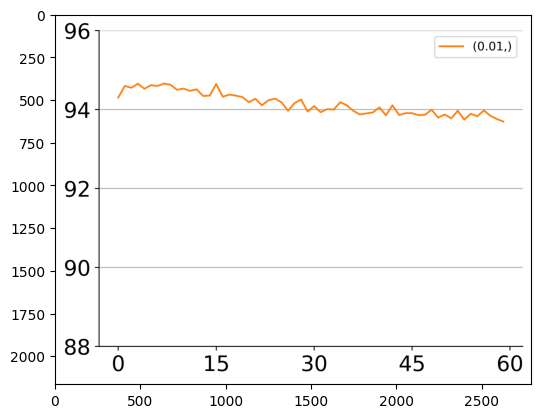

In [16]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/std_net.json', 'accuracy')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 34327.96it/s]


(0.01,) 0 8.244722
[array([[ 0.45      ,  0.28333333,  0.8333334 ,  0.68333334,  0.9166666 ,
         0.46666664,  1.2333333 ,  1.2833333 ,  1.35      ,  2.2       ,
         2.1333332 ,  3.15      ,  3.6833334 ,  3.9166667 ,  6.583333  ,
         5.1166663 ,  6.7666664 ,  5.8666663 ,  5.75      ,  6.1833334 ,
         8.65      ,  7.6       ,  7.6333337 ,  8.533333  ,  9.416667  ,
         7.1166663 ,  8.900001  ,  9.816667  ,  9.3       , 10.016666  ,
        10.450001  , 11.033333  , 10.483334  , 10.233333  , 11.900001  ,
        12.533334  , 11.683333  , 10.533334  , 11.95      , 11.150001  ,
        12.016666  , 10.883333  , 10.583334  , 11.783333  , 11.7       ,
        10.9       , 11.283334  , 12.466667  , 10.116667  , 11.983334  ,
        13.433332  , 11.616667  , 10.616667  , 12.133333  , 12.833333  ,
        13.133333  , 12.666666  , 11.983334  , 12.083333  , 12.683333  ]],
      dtype=float32)]


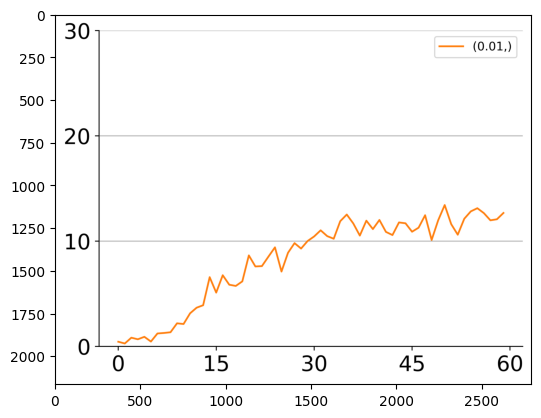

In [17]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/std_net.json', 'dead_neurons')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 18793.09it/s]


(0.01,) 0 0.036433138
[array([[0.03025338, 0.03055773, 0.03085185, 0.03112853, 0.03139959,
        0.03165026, 0.03190101, 0.03214146, 0.03237658, 0.03260974,
        0.03283369, 0.03305093, 0.03326647, 0.03348096, 0.0336884 ,
        0.03389029, 0.03408999, 0.03429473, 0.03449103, 0.03468504,
        0.03487632, 0.03506418, 0.03525197, 0.03544048, 0.03562503,
        0.03581236, 0.03599701, 0.03618259, 0.03636236, 0.03654358,
        0.03672577, 0.03690723, 0.03708683, 0.03725882, 0.03743257,
        0.03760708, 0.03777764, 0.03795257, 0.03812446, 0.03829538,
        0.038466  , 0.0386353 , 0.03880285, 0.03896807, 0.03913675,
        0.03930608, 0.03947174, 0.03964026, 0.03980859, 0.0399736 ,
        0.04013641, 0.04030094, 0.04046629, 0.04062928, 0.04079706,
        0.04096399, 0.04113166, 0.04129828, 0.04146188, 0.0416269 ]],
      dtype=float32)]


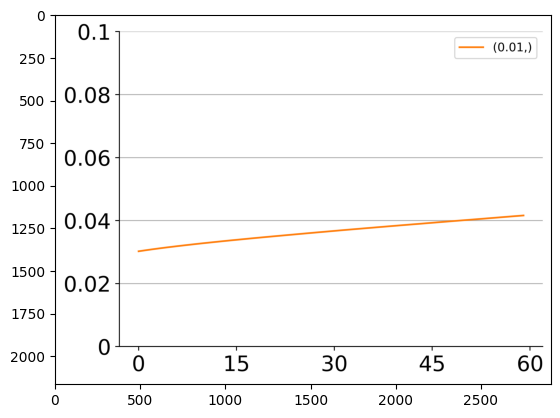

In [18]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/std_net.json', 'weight')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 30012.91it/s]


(0.01,) 0 32.73794
[array([[40.712296, 47.521297, 45.764603, 46.414536, 43.948536, 46.75371 ,
        43.517822, 42.68574 , 43.151978, 40.464413, 40.85467 , 37.820805,
        36.478287, 36.652874, 33.460556, 36.28144 , 32.107296, 33.187008,
        32.966316, 34.18799 , 30.320435, 32.025978, 31.869425, 30.587217,
        31.49247 , 33.581127, 30.954613, 29.06704 , 30.09685 , 28.729391,
        29.262943, 28.586803, 29.293953, 29.396029, 29.455057, 28.393606,
        28.908506, 29.763409, 27.873682, 29.05637 , 27.009647, 29.349415,
        29.985903, 29.240911, 28.391813, 28.966394, 28.80726 , 27.73754 ,
        29.613699, 28.333454, 27.580383, 28.256126, 30.17478 , 28.02274 ,
        27.111025, 27.869091, 28.582003, 28.246405, 28.704435, 28.646448]],
      dtype=float32)]


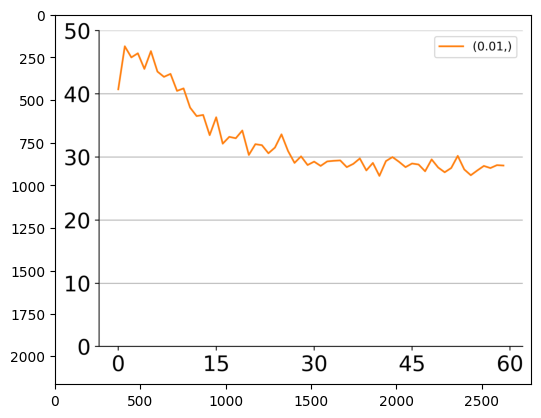

In [19]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/std_net.json', 'effective_rank')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

In [20]:
!mkdir data/bp/small_net
!mkdir data/bp/small_net/0

In [21]:
gen_cfg('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/small_net.json')
with open(f'temp_cfg/0.json', 'r') as f:
    params = json.load(f)
    online_expr(params)

100%|██████████| 1/1 [00:00<00:00, 2761.23it/s]


approximate rank:  tensor([75., 62., 49.]) , dead neurons:  tensor([0., 1., 0.])


100%|██████████| 60000/60000 [01:27<00:00, 684.99it/s]


recent accuracy tensor(0.9245)
approximate rank:  tensor([66., 64., 67.]) , dead neurons:  tensor([0., 0., 0.])


100%|██████████| 60000/60000 [01:29<00:00, 669.88it/s]


recent accuracy tensor(0.9256)
approximate rank:  tensor([56., 62., 52.]) , dead neurons:  tensor([0., 0., 0.])


100%|██████████| 60000/60000 [01:28<00:00, 681.75it/s]


recent accuracy tensor(0.9213)
approximate rank:  tensor([49., 49., 43.]) , dead neurons:  tensor([1., 0., 1.])


100%|██████████| 60000/60000 [01:29<00:00, 670.60it/s]


recent accuracy tensor(0.9206)
approximate rank:  tensor([44., 44., 40.]) , dead neurons:  tensor([5., 0., 0.])


100%|██████████| 60000/60000 [01:27<00:00, 684.29it/s]


recent accuracy tensor(0.9168)
approximate rank:  tensor([34., 35., 31.]) , dead neurons:  tensor([7., 5., 5.])


100%|██████████| 60000/60000 [01:29<00:00, 671.14it/s]


recent accuracy tensor(0.9110)
approximate rank:  tensor([35., 44., 43.]) , dead neurons:  tensor([11.,  3.,  0.])


100%|██████████| 60000/60000 [01:28<00:00, 681.47it/s]


recent accuracy tensor(0.9077)
approximate rank:  tensor([37., 49., 46.]) , dead neurons:  tensor([9., 3., 3.])


100%|██████████| 60000/60000 [01:30<00:00, 665.24it/s]


recent accuracy tensor(0.9062)
approximate rank:  tensor([26., 35., 39.]) , dead neurons:  tensor([11.,  3.,  9.])


100%|██████████| 60000/60000 [01:27<00:00, 682.21it/s]


recent accuracy tensor(0.9027)
approximate rank:  tensor([22., 28., 27.]) , dead neurons:  tensor([ 7., 11., 14.])


100%|██████████| 60000/60000 [01:29<00:00, 670.47it/s]


recent accuracy tensor(0.8934)
approximate rank:  tensor([32., 42., 35.]) , dead neurons:  tensor([12.,  1.,  4.])


100%|██████████| 60000/60000 [01:28<00:00, 681.51it/s]


recent accuracy tensor(0.9050)
approximate rank:  tensor([32., 49., 34.]) , dead neurons:  tensor([8., 1., 4.])


100%|██████████| 60000/60000 [01:30<00:00, 660.56it/s]


recent accuracy tensor(0.9047)
approximate rank:  tensor([37., 48., 36.]) , dead neurons:  tensor([9., 3., 3.])


100%|██████████| 60000/60000 [01:30<00:00, 665.01it/s]


recent accuracy tensor(0.9001)
approximate rank:  tensor([27., 31., 23.]) , dead neurons:  tensor([10.,  4., 11.])


100%|██████████| 60000/60000 [01:30<00:00, 661.37it/s]


recent accuracy tensor(0.8943)
approximate rank:  tensor([27., 35., 27.]) , dead neurons:  tensor([10.,  5., 15.])


100%|██████████| 60000/60000 [01:28<00:00, 674.48it/s]


recent accuracy tensor(0.9005)
approximate rank:  tensor([35., 43., 28.]) , dead neurons:  tensor([11.,  4.,  7.])


100%|██████████| 60000/60000 [01:30<00:00, 665.94it/s]


recent accuracy tensor(0.8967)
approximate rank:  tensor([38., 49., 35.]) , dead neurons:  tensor([9., 4., 5.])


100%|██████████| 60000/60000 [01:28<00:00, 674.52it/s]


recent accuracy tensor(0.8970)
approximate rank:  tensor([35., 41., 28.]) , dead neurons:  tensor([ 9.,  6., 12.])


100%|██████████| 60000/60000 [01:30<00:00, 662.25it/s]


recent accuracy tensor(0.8978)
approximate rank:  tensor([34., 33., 25.]) , dead neurons:  tensor([ 7., 11., 21.])


100%|██████████| 60000/60000 [01:28<00:00, 678.87it/s]


recent accuracy tensor(0.8936)
approximate rank:  tensor([28., 33., 34.]) , dead neurons:  tensor([12., 13.,  6.])


100%|██████████| 60000/60000 [01:31<00:00, 658.25it/s]


recent accuracy tensor(0.8912)
approximate rank:  tensor([29., 33., 39.]) , dead neurons:  tensor([18., 10.,  7.])


100%|██████████| 60000/60000 [01:28<00:00, 675.28it/s]


recent accuracy tensor(0.8961)
approximate rank:  tensor([31., 25., 18.]) , dead neurons:  tensor([11.,  8., 19.])


100%|██████████| 60000/60000 [01:30<00:00, 660.86it/s]


recent accuracy tensor(0.8860)
approximate rank:  tensor([29., 36., 26.]) , dead neurons:  tensor([ 9., 13., 13.])


100%|██████████| 60000/60000 [01:29<00:00, 671.75it/s]


recent accuracy tensor(0.8907)
approximate rank:  tensor([29., 35., 30.]) , dead neurons:  tensor([13.,  7., 10.])


100%|██████████| 60000/60000 [01:30<00:00, 666.49it/s]


recent accuracy tensor(0.8826)
approximate rank:  tensor([27., 31., 37.]) , dead neurons:  tensor([16., 22.,  4.])


100%|██████████| 60000/60000 [01:29<00:00, 667.38it/s]


recent accuracy tensor(0.8875)
approximate rank:  tensor([28., 23., 25.]) , dead neurons:  tensor([12., 16., 13.])


100%|██████████| 60000/60000 [01:29<00:00, 673.20it/s]


recent accuracy tensor(0.8844)
approximate rank:  tensor([27., 27., 27.]) , dead neurons:  tensor([15., 16., 10.])


100%|██████████| 60000/60000 [01:27<00:00, 685.25it/s]


recent accuracy tensor(0.8825)
approximate rank:  tensor([40., 51., 26.]) , dead neurons:  tensor([12.,  3., 12.])


100%|██████████| 60000/60000 [01:27<00:00, 682.28it/s]


recent accuracy tensor(0.8860)
approximate rank:  tensor([29., 29., 21.]) , dead neurons:  tensor([ 9.,  6., 12.])


100%|██████████| 60000/60000 [01:27<00:00, 686.28it/s]


recent accuracy tensor(0.8889)
approximate rank:  tensor([27., 32., 27.]) , dead neurons:  tensor([15.,  8.,  9.])


100%|██████████| 60000/60000 [01:29<00:00, 673.58it/s]


recent accuracy tensor(0.8866)
approximate rank:  tensor([33., 33., 24.]) , dead neurons:  tensor([10.,  4., 15.])


100%|██████████| 60000/60000 [01:27<00:00, 687.27it/s]


recent accuracy tensor(0.8849)
approximate rank:  tensor([28., 30., 34.]) , dead neurons:  tensor([15., 12.,  7.])


100%|██████████| 60000/60000 [01:26<00:00, 689.75it/s]


recent accuracy tensor(0.8797)
approximate rank:  tensor([22., 15., 18.]) , dead neurons:  tensor([11., 30., 36.])


100%|██████████| 60000/60000 [01:29<00:00, 667.45it/s]


recent accuracy tensor(0.8677)
approximate rank:  tensor([26., 15., 19.]) , dead neurons:  tensor([10., 26., 23.])


100%|██████████| 60000/60000 [01:27<00:00, 683.22it/s]


recent accuracy tensor(0.8665)
approximate rank:  tensor([26., 24., 22.]) , dead neurons:  tensor([12., 15., 19.])


100%|██████████| 60000/60000 [01:29<00:00, 667.58it/s]


recent accuracy tensor(0.8783)
approximate rank:  tensor([27., 26., 25.]) , dead neurons:  tensor([12.,  9., 22.])


100%|██████████| 60000/60000 [01:28<00:00, 674.33it/s]


recent accuracy tensor(0.8656)
approximate rank:  tensor([25., 15., 15.]) , dead neurons:  tensor([17., 24., 29.])


100%|██████████| 60000/60000 [01:27<00:00, 687.26it/s]


recent accuracy tensor(0.8703)
approximate rank:  tensor([26., 23., 29.]) , dead neurons:  tensor([17., 19., 22.])


100%|██████████| 60000/60000 [01:27<00:00, 683.19it/s]


recent accuracy tensor(0.8711)
approximate rank:  tensor([22., 21., 18.]) , dead neurons:  tensor([14., 20., 20.])


100%|██████████| 60000/60000 [01:30<00:00, 665.00it/s]


recent accuracy tensor(0.8561)
approximate rank:  tensor([20., 21., 22.]) , dead neurons:  tensor([13., 38., 27.])


100%|██████████| 60000/60000 [01:27<00:00, 686.14it/s]


recent accuracy tensor(0.8767)
approximate rank:  tensor([21., 19., 24.]) , dead neurons:  tensor([17., 31., 17.])


100%|██████████| 60000/60000 [01:27<00:00, 683.27it/s]


recent accuracy tensor(0.8779)
approximate rank:  tensor([20., 14., 21.]) , dead neurons:  tensor([20., 42., 24.])


100%|██████████| 60000/60000 [01:28<00:00, 676.83it/s]


recent accuracy tensor(0.8548)
approximate rank:  tensor([23., 21., 28.]) , dead neurons:  tensor([10., 25., 17.])


100%|██████████| 60000/60000 [01:29<00:00, 671.72it/s]


recent accuracy tensor(0.8787)
approximate rank:  tensor([26., 30., 26.]) , dead neurons:  tensor([14., 15., 17.])


100%|██████████| 60000/60000 [01:27<00:00, 687.38it/s]


recent accuracy tensor(0.8707)
approximate rank:  tensor([28., 24., 21.]) , dead neurons:  tensor([11., 14., 26.])


100%|██████████| 60000/60000 [01:27<00:00, 684.81it/s]


recent accuracy tensor(0.8663)
approximate rank:  tensor([29., 35., 29.]) , dead neurons:  tensor([19., 13., 16.])


100%|██████████| 60000/60000 [01:29<00:00, 668.69it/s]


recent accuracy tensor(0.8679)
approximate rank:  tensor([25., 32., 19.]) , dead neurons:  tensor([17.,  9., 24.])


100%|██████████| 60000/60000 [01:27<00:00, 685.25it/s]


recent accuracy tensor(0.8710)
approximate rank:  tensor([23., 20., 21.]) , dead neurons:  tensor([18., 18., 23.])


100%|██████████| 60000/60000 [01:28<00:00, 681.23it/s]


recent accuracy tensor(0.8683)
approximate rank:  tensor([27., 37., 29.]) , dead neurons:  tensor([19., 16., 13.])


100%|██████████| 60000/60000 [01:30<00:00, 664.90it/s]


recent accuracy tensor(0.8754)
approximate rank:  tensor([27., 29., 20.]) , dead neurons:  tensor([19., 14., 28.])


100%|██████████| 60000/60000 [01:27<00:00, 685.00it/s]


recent accuracy tensor(0.8636)
approximate rank:  tensor([27., 32., 22.]) , dead neurons:  tensor([17., 17., 14.])


100%|██████████| 60000/60000 [01:27<00:00, 684.84it/s]


recent accuracy tensor(0.8599)
approximate rank:  tensor([25., 28., 20.]) , dead neurons:  tensor([21., 15., 26.])


100%|██████████| 60000/60000 [01:28<00:00, 681.04it/s]


recent accuracy tensor(0.8565)
approximate rank:  tensor([25., 27., 26.]) , dead neurons:  tensor([18., 32., 15.])


100%|██████████| 60000/60000 [01:29<00:00, 667.34it/s]


recent accuracy tensor(0.8628)
approximate rank:  tensor([24., 25., 26.]) , dead neurons:  tensor([18., 17., 23.])


100%|██████████| 60000/60000 [01:27<00:00, 686.16it/s]


recent accuracy tensor(0.8563)
approximate rank:  tensor([17., 16., 18.]) , dead neurons:  tensor([20., 45., 29.])


100%|██████████| 60000/60000 [01:28<00:00, 680.44it/s]


recent accuracy tensor(0.8645)
approximate rank:  tensor([19., 22., 22.]) , dead neurons:  tensor([22., 24., 18.])


100%|██████████| 60000/60000 [01:30<00:00, 660.72it/s]


recent accuracy tensor(0.8583)
approximate rank:  tensor([23., 28., 28.]) , dead neurons:  tensor([20., 15., 19.])


100%|██████████| 60000/60000 [01:28<00:00, 679.52it/s]


recent accuracy tensor(0.8521)
approximate rank:  tensor([25., 39., 30.]) , dead neurons:  tensor([15.,  9., 17.])


100%|██████████| 60000/60000 [01:28<00:00, 681.08it/s]


recent accuracy tensor(0.8533)
approximate rank:  tensor([23., 14., 15.]) , dead neurons:  tensor([19., 33., 21.])


100%|██████████| 60000/60000 [01:28<00:00, 680.78it/s]


recent accuracy tensor(0.8583)
approximate rank:  tensor([29., 35., 23.]) , dead neurons:  tensor([19.,  9., 31.])


100%|██████████| 60000/60000 [01:30<00:00, 661.99it/s]


recent accuracy tensor(0.8536)


100%|██████████| 60/60 [00:00<00:00, 19030.42it/s]


(0.01,) 0 88.28261
[array([[92.455   , 92.56333 , 92.13167 , 92.05666 , 91.685   , 91.10167 ,
        90.775   , 90.62334 , 90.26667 , 89.34    , 90.50166 , 90.46833 ,
        90.01    , 89.42834 , 90.055   , 89.67333 , 89.69833 , 89.78167 ,
        89.365   , 89.11667 , 89.61    , 88.598335, 89.075   , 88.25833 ,
        88.74834 , 88.44334 , 88.25166 , 88.605   , 88.89333 , 88.66333 ,
        88.486664, 87.97    , 86.76833 , 86.655   , 87.82667 , 86.56333 ,
        87.035   , 87.111664, 85.611664, 87.67167 , 87.79    , 85.475   ,
        87.86833 , 87.066666, 86.628334, 86.793335, 87.096664, 86.82833 ,
        87.53833 , 86.35833 , 85.99167 , 85.653336, 86.285   , 85.628334,
        86.44833 , 85.83    , 85.21167 , 85.33    , 85.83    , 85.361664]],
      dtype=float32)]


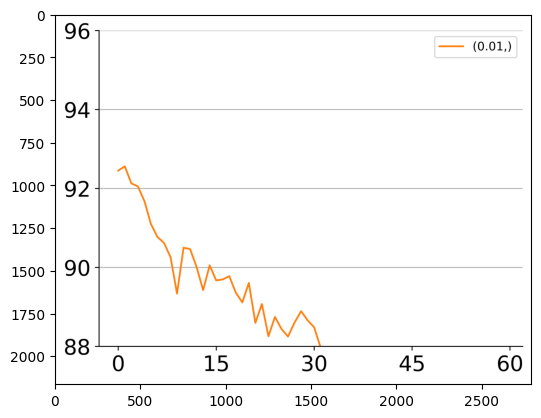

In [22]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/small_net.json', 'accuracy')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 31702.98it/s]


(0.01,) 0 0.673889
[array([[0.01666667, 0.        , 0.        , 0.03333333, 0.08333334,
        0.28333333, 0.23333332, 0.25      , 0.38333333, 0.5333333 ,
        0.28333333, 0.21666665, 0.25      , 0.4166667 , 0.5       ,
        0.36666664, 0.3       , 0.45      , 0.65000004, 0.51666665,
        0.5833333 , 0.6333333 , 0.5833333 , 0.5       , 0.70000005,
        0.68333334, 0.68333334, 0.45      , 0.45      , 0.5333333 ,
        0.48333332, 0.56666666, 1.2833333 , 0.9833333 , 0.76666665,
        0.71666664, 1.1666666 , 0.96666664, 0.9       , 1.3000001 ,
        1.0833334 , 1.4333333 , 0.8666666 , 0.76666665, 0.85      ,
        0.8       , 0.8333334 , 0.9833333 , 0.8       , 1.0166667 ,
        0.8       , 1.0333333 , 1.0833334 , 0.96666664, 1.5666667 ,
        1.0666666 , 0.9       , 0.68333334, 1.2166667 , 0.9833333 ]],
      dtype=float32)]


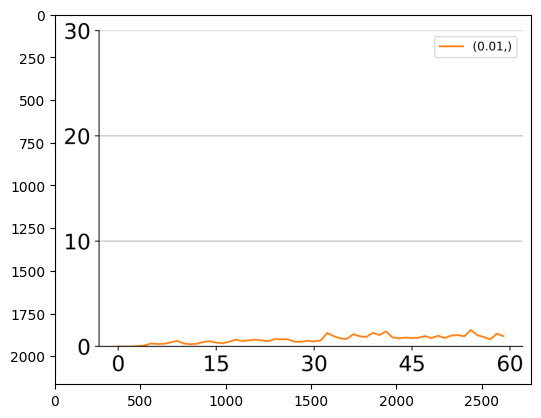

In [23]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/small_net.json', 'dead_neurons')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 17915.44it/s]


(0.01,) 0 0.0018731164
[array([[0.00070541, 0.00081494, 0.00090561, 0.00098135, 0.00105013,
        0.00111021, 0.00116652, 0.00122104, 0.00126829, 0.00131357,
        0.00135593, 0.00139979, 0.00144268, 0.00148084, 0.00151741,
        0.00155469, 0.0015888 , 0.00162403, 0.0016579 , 0.00169282,
        0.00172301, 0.00175167, 0.00178452, 0.00181383, 0.00184325,
        0.00187   , 0.00189319, 0.00191595, 0.00193771, 0.00196221,
        0.00198727, 0.0020116 , 0.00203357, 0.00205559, 0.00207389,
        0.00209577, 0.00211712, 0.00213655, 0.00215341, 0.00216932,
        0.00218827, 0.00221061, 0.00223216, 0.00225226, 0.00227183,
        0.00229184, 0.00230792, 0.00232633, 0.00234328, 0.00236045,
        0.00237645, 0.00239157, 0.00240777, 0.00242086, 0.00243237,
        0.00244444, 0.00246113, 0.00247778, 0.00249562, 0.00251267]],
      dtype=float32)]


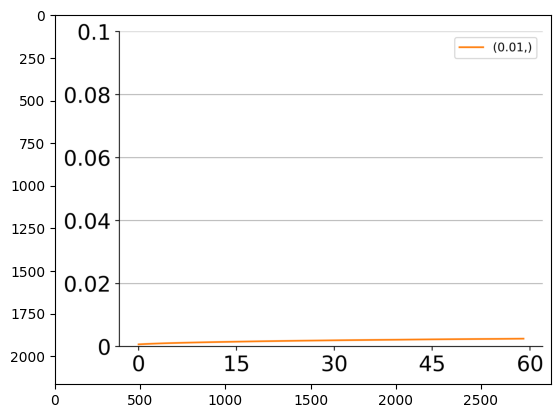

In [24]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/small_net.json', 'weight')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 36647.48it/s]


(0.01,) 0 1.6158065
[array([[2.816396 , 2.9136083, 2.661766 , 2.3163474, 2.1429362, 1.6904625,
        2.0317588, 2.2369177, 1.7997876, 1.4129657, 1.9187844, 2.0418277,
        2.047741 , 1.496828 , 1.6001556, 1.8542417, 2.0610912, 1.831443 ,
        1.5900339, 1.7073168, 1.808137 , 1.3569436, 1.6529202, 1.6797229,
        1.6927257, 1.4330184, 1.5033829, 1.9990488, 1.4635262, 1.5816015,
        1.6497543, 1.6452146, 1.0375513, 1.1371287, 1.3428928, 1.4522694,
        1.0897388, 1.4128015, 1.1832289, 1.1986327, 1.1917247, 1.0420339,
        1.3547256, 1.4920341, 1.388403 , 1.7131103, 1.4011112, 1.263613 ,
        1.6570672, 1.3691362, 1.4577866, 1.3292259, 1.4251224, 1.4742916,
        0.9593076, 1.2262092, 1.4732826, 1.6901157, 1.0064622, 1.5409795]],
      dtype=float32)]


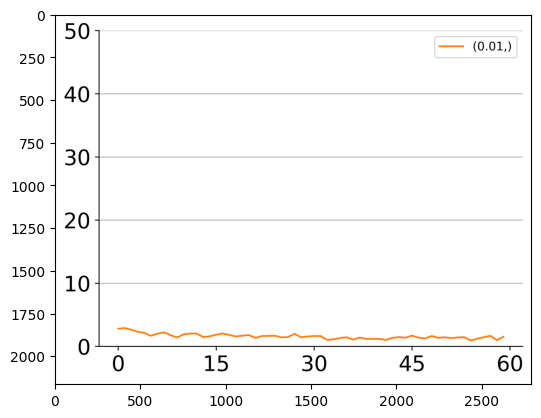

In [25]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/bp/small_net.json', 'effective_rank')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

In [26]:
!mkdir data/adam
!mkdir data/adam/0

In [27]:
gen_cfg('/kaggle/working/lop/lop/permuted_mnist/cfg/adam.json')
with open(f'temp_cfg/0.json', 'r') as f:
    params = json.load(f)
    online_expr(params)

100%|██████████| 10/10 [00:00<00:00, 2684.53it/s]


approximate rank:  tensor([693., 713., 649.]) , dead neurons:  tensor([ 0.,  2., 18.])


100%|██████████| 60000/60000 [03:25<00:00, 291.29it/s]


recent accuracy tensor(0.9427)
approximate rank:  tensor([752., 341.,  38.]) , dead neurons:  tensor([  0., 210., 217.])


100%|██████████| 60000/60000 [03:27<00:00, 288.49it/s]


recent accuracy tensor(0.9429)
approximate rank:  tensor([655., 143.,  12.]) , dead neurons:  tensor([  6., 315., 291.])


100%|██████████| 60000/60000 [03:26<00:00, 290.70it/s]


recent accuracy tensor(0.9423)
approximate rank:  tensor([493.,  45.,  40.]) , dead neurons:  tensor([  9., 861., 773.])


100%|██████████| 60000/60000 [03:25<00:00, 292.53it/s]


recent accuracy tensor(0.9433)
approximate rank:  tensor([410.,  24.,  11.]) , dead neurons:  tensor([ 12., 909., 893.])


100%|██████████| 60000/60000 [03:23<00:00, 294.12it/s]


recent accuracy tensor(0.9423)
approximate rank:  tensor([281.,  10.,  37.]) , dead neurons:  tensor([   8., 1352., 1189.])


100%|██████████| 60000/60000 [03:24<00:00, 293.83it/s]


recent accuracy tensor(0.9460)
approximate rank:  tensor([258.,  12.,  28.]) , dead neurons:  tensor([  19., 1309., 1131.])


100%|██████████| 60000/60000 [03:23<00:00, 294.55it/s]


recent accuracy tensor(0.9447)
approximate rank:  tensor([189.,   8.,  48.]) , dead neurons:  tensor([  14., 1623., 1455.])


100%|██████████| 60000/60000 [03:24<00:00, 293.57it/s]


recent accuracy tensor(0.9442)
approximate rank:  tensor([138.,   6.,  38.]) , dead neurons:  tensor([  22., 1688., 1447.])


100%|██████████| 60000/60000 [03:24<00:00, 293.97it/s]


recent accuracy tensor(0.9426)
approximate rank:  tensor([127.,   8.,  38.]) , dead neurons:  tensor([  29., 1675., 1413.])


100%|██████████| 60000/60000 [03:23<00:00, 294.65it/s]


recent accuracy tensor(0.9433)
approximate rank:  tensor([98.,  7., 23.]) , dead neurons:  tensor([  20., 1659., 1332.])


100%|██████████| 60000/60000 [03:24<00:00, 293.56it/s]


recent accuracy tensor(0.9417)
approximate rank:  tensor([110.,   8.,  44.]) , dead neurons:  tensor([  16., 1760., 1413.])


100%|██████████| 60000/60000 [03:24<00:00, 293.39it/s]


recent accuracy tensor(0.9409)
approximate rank:  tensor([83.,  7., 45.]) , dead neurons:  tensor([  42., 1832., 1521.])


100%|██████████| 60000/60000 [03:23<00:00, 294.93it/s]


recent accuracy tensor(0.9412)
approximate rank:  tensor([75.,  7., 43.]) , dead neurons:  tensor([  32., 1854., 1478.])


100%|██████████| 60000/60000 [03:23<00:00, 294.18it/s]


recent accuracy tensor(0.9411)
approximate rank:  tensor([61.,  7., 50.]) , dead neurons:  tensor([  45., 1908., 1531.])


100%|██████████| 60000/60000 [03:23<00:00, 295.29it/s]


recent accuracy tensor(0.9404)
approximate rank:  tensor([74.,  8., 26.]) , dead neurons:  tensor([  38., 1837., 1318.])


100%|██████████| 60000/60000 [03:22<00:00, 296.38it/s]


recent accuracy tensor(0.9393)
approximate rank:  tensor([61.,  6., 42.]) , dead neurons:  tensor([  41., 1893., 1420.])


100%|██████████| 60000/60000 [03:22<00:00, 296.00it/s]


recent accuracy tensor(0.9415)
approximate rank:  tensor([49.,  5., 50.]) , dead neurons:  tensor([  53., 1927., 1531.])


100%|██████████| 60000/60000 [03:25<00:00, 292.64it/s]


recent accuracy tensor(0.9399)
approximate rank:  tensor([40.,  4., 40.]) , dead neurons:  tensor([  64., 1929., 1450.])


100%|██████████| 60000/60000 [03:24<00:00, 293.77it/s]


recent accuracy tensor(0.9393)
approximate rank:  tensor([35.,  4., 51.]) , dead neurons:  tensor([  72., 1948., 1517.])


100%|██████████| 60000/60000 [03:24<00:00, 293.12it/s]


recent accuracy tensor(0.9394)
approximate rank:  tensor([32.,  3., 34.]) , dead neurons:  tensor([  68., 1960., 1664.])


100%|██████████| 60000/60000 [03:24<00:00, 294.06it/s]


recent accuracy tensor(0.9400)
approximate rank:  tensor([34.,  4., 47.]) , dead neurons:  tensor([  75., 1954., 1516.])


100%|██████████| 60000/60000 [03:24<00:00, 293.52it/s]


recent accuracy tensor(0.9393)
approximate rank:  tensor([25.,  3., 40.]) , dead neurons:  tensor([  82., 1963., 1572.])


100%|██████████| 60000/60000 [03:24<00:00, 293.70it/s]


recent accuracy tensor(0.9407)
approximate rank:  tensor([31.,  4., 50.]) , dead neurons:  tensor([  71., 1948., 1437.])


100%|██████████| 60000/60000 [03:24<00:00, 292.85it/s]


recent accuracy tensor(0.9368)
approximate rank:  tensor([19.,  2., 42.]) , dead neurons:  tensor([  74., 1975., 1743.])


100%|██████████| 60000/60000 [03:23<00:00, 294.30it/s]


recent accuracy tensor(0.9380)
approximate rank:  tensor([16.,  1., 28.]) , dead neurons:  tensor([  79., 1971., 1652.])


100%|██████████| 60000/60000 [03:23<00:00, 294.49it/s]


recent accuracy tensor(0.9395)
approximate rank:  tensor([14.,  1., 25.]) , dead neurons:  tensor([  81., 1972., 1710.])


100%|██████████| 60000/60000 [03:21<00:00, 298.23it/s]


recent accuracy tensor(0.9381)
approximate rank:  tensor([20.,  2., 28.]) , dead neurons:  tensor([  81., 1975., 1693.])


100%|██████████| 60000/60000 [03:23<00:00, 295.13it/s]


recent accuracy tensor(0.9373)
approximate rank:  tensor([13.,  1., 18.]) , dead neurons:  tensor([ 105., 1983., 1823.])


100%|██████████| 60000/60000 [03:20<00:00, 298.56it/s]


recent accuracy tensor(0.9375)
approximate rank:  tensor([18.,  1., 21.]) , dead neurons:  tensor([  98., 1977., 1712.])


100%|██████████| 60000/60000 [03:22<00:00, 295.98it/s]


recent accuracy tensor(0.9382)
approximate rank:  tensor([24.,  2., 40.]) , dead neurons:  tensor([  98., 1975., 1694.])


100%|██████████| 60000/60000 [03:20<00:00, 299.09it/s]


recent accuracy tensor(0.9373)
approximate rank:  tensor([21.,  1., 21.]) , dead neurons:  tensor([  80., 1978., 1768.])


100%|██████████| 60000/60000 [03:24<00:00, 294.00it/s]


recent accuracy tensor(0.9373)
approximate rank:  tensor([19.,  1., 37.]) , dead neurons:  tensor([  88., 1974., 1677.])


100%|██████████| 60000/60000 [03:20<00:00, 299.08it/s]


recent accuracy tensor(0.9374)
approximate rank:  tensor([15.,  1., 31.]) , dead neurons:  tensor([  87., 1979., 1735.])


100%|██████████| 60000/60000 [03:22<00:00, 295.74it/s]


recent accuracy tensor(0.9374)
approximate rank:  tensor([17.,  1., 30.]) , dead neurons:  tensor([ 102., 1978., 1754.])


100%|██████████| 60000/60000 [03:21<00:00, 298.24it/s]


recent accuracy tensor(0.9370)
approximate rank:  tensor([14.,  1., 40.]) , dead neurons:  tensor([ 101., 1978., 1740.])


100%|██████████| 60000/60000 [03:22<00:00, 296.63it/s]


recent accuracy tensor(0.9362)
approximate rank:  tensor([17.,  1., 36.]) , dead neurons:  tensor([ 104., 1978., 1699.])


100%|██████████| 60000/60000 [03:22<00:00, 296.09it/s]


recent accuracy tensor(0.9366)
approximate rank:  tensor([13.,  1., 27.]) , dead neurons:  tensor([  99., 1981., 1750.])


100%|██████████| 60000/60000 [03:21<00:00, 298.34it/s]


recent accuracy tensor(0.9373)
approximate rank:  tensor([10.,  1., 15.]) , dead neurons:  tensor([ 131., 1984., 1871.])


100%|██████████| 60000/60000 [03:23<00:00, 295.17it/s]


recent accuracy tensor(0.9354)
approximate rank:  tensor([13.,  1., 17.]) , dead neurons:  tensor([ 143., 1982., 1843.])


100%|██████████| 60000/60000 [03:21<00:00, 297.80it/s]


recent accuracy tensor(0.9334)
approximate rank:  tensor([18.,  1., 33.]) , dead neurons:  tensor([ 124., 1976., 1709.])


100%|██████████| 60000/60000 [03:22<00:00, 295.81it/s]


recent accuracy tensor(0.9330)
approximate rank:  tensor([13.,  1., 24.]) , dead neurons:  tensor([ 135., 1982., 1810.])


100%|██████████| 60000/60000 [03:21<00:00, 297.33it/s]


recent accuracy tensor(0.9345)
approximate rank:  tensor([12.,  1., 16.]) , dead neurons:  tensor([ 154., 1987., 1863.])


100%|██████████| 60000/60000 [03:23<00:00, 295.15it/s]


recent accuracy tensor(0.9351)
approximate rank:  tensor([19.,  1., 26.]) , dead neurons:  tensor([ 127., 1977., 1711.])


100%|██████████| 60000/60000 [03:21<00:00, 298.04it/s]


recent accuracy tensor(0.9350)
approximate rank:  tensor([14.,  1., 30.]) , dead neurons:  tensor([ 138., 1985., 1799.])


100%|██████████| 60000/60000 [03:24<00:00, 294.11it/s]


recent accuracy tensor(0.9332)
approximate rank:  tensor([19.,  1., 26.]) , dead neurons:  tensor([ 137., 1980., 1736.])


100%|██████████| 60000/60000 [03:21<00:00, 298.12it/s]


recent accuracy tensor(0.9323)
approximate rank:  tensor([14.,  1., 21.]) , dead neurons:  tensor([ 149., 1985., 1861.])


100%|██████████| 60000/60000 [03:24<00:00, 294.03it/s]


recent accuracy tensor(0.9313)
approximate rank:  tensor([14.,  1., 18.]) , dead neurons:  tensor([ 152., 1988., 1884.])


100%|██████████| 60000/60000 [03:21<00:00, 297.79it/s]


recent accuracy tensor(0.9339)
approximate rank:  tensor([23.,  1., 26.]) , dead neurons:  tensor([ 146., 1978., 1719.])


100%|██████████| 60000/60000 [03:23<00:00, 294.15it/s]


recent accuracy tensor(0.9305)
approximate rank:  tensor([17.,  1., 22.]) , dead neurons:  tensor([ 145., 1987., 1900.])


100%|██████████| 60000/60000 [03:21<00:00, 297.65it/s]


recent accuracy tensor(0.9341)
approximate rank:  tensor([24.,  2., 15.]) , dead neurons:  tensor([ 135., 1972., 1609.])


100%|██████████| 60000/60000 [03:23<00:00, 294.99it/s]


recent accuracy tensor(0.9305)
approximate rank:  tensor([24.,  1., 27.]) , dead neurons:  tensor([ 142., 1977., 1708.])


100%|██████████| 60000/60000 [03:22<00:00, 296.96it/s]


recent accuracy tensor(0.9323)
approximate rank:  tensor([19.,  1., 21.]) , dead neurons:  tensor([ 153., 1982., 1790.])


100%|██████████| 60000/60000 [03:22<00:00, 295.99it/s]


recent accuracy tensor(0.9311)
approximate rank:  tensor([24.,  1., 20.]) , dead neurons:  tensor([ 169., 1979., 1761.])


100%|██████████| 60000/60000 [03:22<00:00, 295.79it/s]


recent accuracy tensor(0.9284)
approximate rank:  tensor([24.,  1., 22.]) , dead neurons:  tensor([ 162., 1983., 1778.])


100%|██████████| 60000/60000 [03:21<00:00, 297.50it/s]


recent accuracy tensor(0.9300)
approximate rank:  tensor([20.,  1., 27.]) , dead neurons:  tensor([ 168., 1979., 1801.])


100%|██████████| 60000/60000 [03:23<00:00, 294.87it/s]


recent accuracy tensor(0.9297)
approximate rank:  tensor([20.,  1., 18.]) , dead neurons:  tensor([ 197., 1980., 1783.])


100%|██████████| 60000/60000 [03:21<00:00, 297.67it/s]


recent accuracy tensor(0.9296)
approximate rank:  tensor([25.,  1., 24.]) , dead neurons:  tensor([ 201., 1981., 1794.])


100%|██████████| 60000/60000 [03:24<00:00, 293.43it/s]


recent accuracy tensor(0.9298)
approximate rank:  tensor([21.,  1., 15.]) , dead neurons:  tensor([ 184., 1982., 1905.])


100%|██████████| 60000/60000 [03:21<00:00, 297.76it/s]


recent accuracy tensor(0.9316)
approximate rank:  tensor([24.,  1., 19.]) , dead neurons:  tensor([ 178., 1979., 1746.])


100%|██████████| 60000/60000 [03:24<00:00, 292.87it/s]


recent accuracy tensor(0.9328)


100%|██████████| 60/60 [00:00<00:00, 19033.30it/s]


(0.0001,) 0 93.71429
[array([[94.26667 , 94.28833 , 94.22667 , 94.33    , 94.235   , 94.596664,
        94.46833 , 94.42167 , 94.261665, 94.32833 , 94.166664, 94.08833 ,
        94.11667 , 94.10667 , 94.043335, 93.92834 , 94.15    , 93.988335,
        93.92667 , 93.93667 , 94.003334, 93.92834 , 94.07166 , 93.683334,
        93.8     , 93.95167 , 93.81    , 93.73333 , 93.74834 , 93.81834 ,
        93.72667 , 93.72667 , 93.74167 , 93.745   , 93.7     , 93.62    ,
        93.65833 , 93.73167 , 93.545   , 93.33667 , 93.29667 , 93.44833 ,
        93.513336, 93.496666, 93.32    , 93.235   , 93.135   , 93.39    ,
        93.055   , 93.41333 , 93.055   , 93.22833 , 93.111664, 92.845   ,
        93.005   , 92.971664, 92.96    , 92.98    , 93.16333 , 93.278336]],
      dtype=float32)]


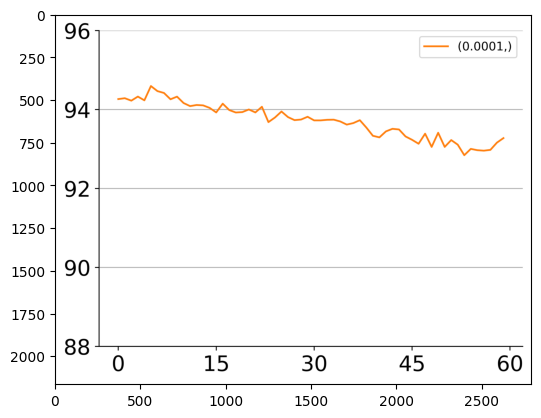

In [28]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/adam.json', 'accuracy')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 34797.88it/s]


(0.0001,) 0 57.255
[array([[ 0.33333334,  7.1166663 , 10.2       , 27.383333  , 30.233332  ,
        42.483334  , 40.983334  , 51.533337  , 52.61667   , 51.95      ,
        50.18333   , 53.149998  , 56.583332  , 56.06667   , 58.066666  ,
        53.216667  , 55.9       , 58.51667   , 57.383335  , 58.95      ,
        61.533333  , 59.083332  , 60.283333  , 57.6       , 63.200005  ,
        61.699997  , 62.716667  , 62.483334  , 65.183334  , 63.116665  ,
        62.78333   , 63.766663  , 62.31667   , 63.35      , 63.9       ,
        63.65      , 63.016666  , 63.833332  , 66.433334  , 66.13333   ,
        63.483334  , 65.45      , 66.73333   , 63.583332  , 65.36667   ,
        64.21667   , 66.583336  , 67.066666  , 64.05      , 67.2       ,
        61.933334  , 63.783337  , 65.416664  , 65.15      , 65.38333   ,
        65.8       , 66.        , 66.26667   , 67.85      , 65.05      ]],
      dtype=float32)]


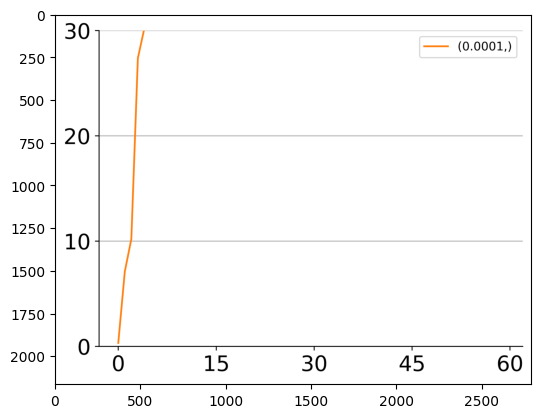

In [29]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/adam.json', 'dead_neurons')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 20526.77it/s]


(0.0001,) 0 0.041898098
[array([[0.03147535, 0.03349293, 0.03470828, 0.0355507 , 0.03618611,
        0.03672293, 0.03716193, 0.03755602, 0.03792102, 0.03823898,
        0.03854148, 0.03882144, 0.03909489, 0.03934512, 0.03959971,
        0.03983413, 0.04006788, 0.04029744, 0.040511  , 0.04070947,
        0.0409185 , 0.04112557, 0.04132545, 0.04152   , 0.04171043,
        0.04188967, 0.04205789, 0.042229  , 0.04239746, 0.04256373,
        0.04272955, 0.04289175, 0.04305391, 0.04321029, 0.0433638 ,
        0.04351533, 0.0436602 , 0.0437959 , 0.04392825, 0.04406161,
        0.0441902 , 0.04431481, 0.04443608, 0.04455442, 0.04467796,
        0.04479329, 0.04491105, 0.04502643, 0.04514118, 0.04525925,
        0.04537236, 0.04548748, 0.04560706, 0.04572137, 0.045833  ,
        0.04594648, 0.04605634, 0.04615657, 0.04625661, 0.0463591 ]],
      dtype=float32)]


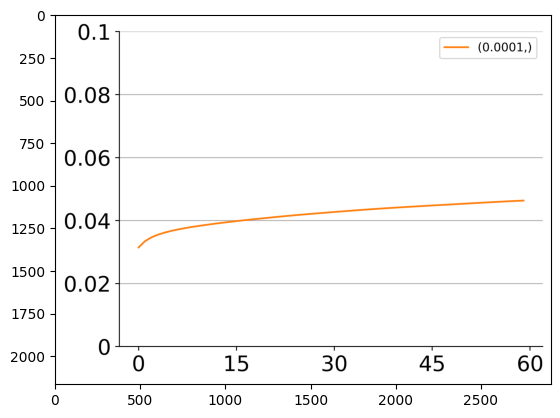

In [30]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/adam.json', 'weight')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 33008.69it/s]


(0.0001,) 0 7.7702484
[array([[40.782345 , 27.47311  , 21.82986  , 17.491125 , 14.813788 ,
        12.424512 , 12.140153 , 10.739898 ,  9.509582 ,  9.517638 ,
         8.686903 ,  9.422324 ,  8.531611 ,  8.325687 ,  7.883036 ,
         8.494954 ,  7.892129 ,  7.4212527,  6.992002 ,  6.7878246,
         6.349361 ,  6.845231 ,  6.1086493,  6.7639832,  5.733525 ,
         5.301779 ,  5.026309 ,  5.5614405,  4.9379187,  5.129352 ,
         5.881074 ,  5.380677 ,  5.5939107,  5.2473526,  5.1626587,
         5.2682004,  5.3265533,  5.091701 ,  4.1829963,  4.5815425,
         5.273812 ,  4.576576 ,  4.4252152,  5.140381 ,  4.8136926,
         4.9885936,  4.7103176,  4.6788287,  5.242976 ,  4.912786 ,
         5.334627 ,  5.3070683,  4.986437 ,  5.1644206,  5.155084 ,
         5.0165663,  4.730464 ,  5.1603374,  4.8204365,  5.142293 ]],
      dtype=float32)]


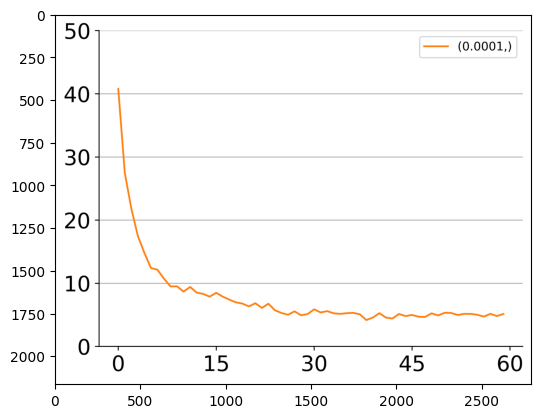

In [31]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/adam.json', 'effective_rank')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

In [32]:
!mkdir data/cbp
!mkdir data/cbp/0

In [33]:
cfg = {
    "model_version": "CBP on net with 3 hidden layer and 2000 hidden-units",
    "num_runs":  1,
    "num_tasks": 60,
    "use_gpu": 1,
    "data_dir": "data/cbp/0/",
    "to_log": True,

    "agent": "cbp",
    "opt": "sgd",
    "num_features": 500,
    "num_hidden_layers": 3,
    "step_size": 0.003,
    "accumulate": True,
    "util_type": "adaptable_contribution",
    "replacement_rate": 1e-4,
    "decay_rate": 0.99,
    "mt": 100,
    "index": 0,
    "data_file": "data/cbp/0/0"
}
online_expr(cfg)

approximate rank:  tensor([321., 280., 228.]) , dead neurons:  tensor([0., 0., 4.])


100%|██████████| 60000/60000 [02:55<00:00, 342.79it/s]


recent accuracy tensor(0.9327)
approximate rank:  tensor([320., 306., 270.]) , dead neurons:  tensor([0., 0., 0.])


100%|██████████| 60000/60000 [02:54<00:00, 344.76it/s]


recent accuracy tensor(0.9408)
approximate rank:  tensor([325., 301., 260.]) , dead neurons:  tensor([0., 0., 0.])


100%|██████████| 60000/60000 [02:54<00:00, 343.57it/s]


recent accuracy tensor(0.9422)
approximate rank:  tensor([324., 311., 272.]) , dead neurons:  tensor([0., 0., 1.])


100%|██████████| 60000/60000 [02:59<00:00, 333.58it/s]


recent accuracy tensor(0.9448)
approximate rank:  tensor([312., 240., 175.]) , dead neurons:  tensor([0., 1., 3.])


100%|██████████| 60000/60000 [02:55<00:00, 341.89it/s]


recent accuracy tensor(0.9434)
approximate rank:  tensor([320., 283., 235.]) , dead neurons:  tensor([0., 0., 0.])


100%|██████████| 60000/60000 [02:54<00:00, 344.29it/s]


recent accuracy tensor(0.9421)
approximate rank:  tensor([312., 214., 150.]) , dead neurons:  tensor([0., 1., 4.])


100%|██████████| 60000/60000 [02:54<00:00, 343.94it/s]


recent accuracy tensor(0.9429)
approximate rank:  tensor([332., 221., 171.]) , dead neurons:  tensor([0., 5., 4.])


100%|██████████| 60000/60000 [03:00<00:00, 331.56it/s]


recent accuracy tensor(0.9449)
approximate rank:  tensor([308., 189., 105.]) , dead neurons:  tensor([0., 6., 8.])


100%|██████████| 60000/60000 [02:54<00:00, 343.42it/s]


recent accuracy tensor(0.9440)
approximate rank:  tensor([321., 206., 141.]) , dead neurons:  tensor([0., 3., 1.])


100%|██████████| 60000/60000 [02:54<00:00, 343.11it/s]


recent accuracy tensor(0.9436)
approximate rank:  tensor([322., 192., 125.]) , dead neurons:  tensor([0., 0., 0.])


100%|██████████| 60000/60000 [02:54<00:00, 343.74it/s]


recent accuracy tensor(0.9445)
approximate rank:  tensor([324., 211., 138.]) , dead neurons:  tensor([0., 1., 2.])


100%|██████████| 60000/60000 [03:01<00:00, 331.06it/s]


recent accuracy tensor(0.9432)
approximate rank:  tensor([327., 205., 132.]) , dead neurons:  tensor([0., 1., 2.])


100%|██████████| 60000/60000 [02:54<00:00, 343.02it/s]


recent accuracy tensor(0.9450)
approximate rank:  tensor([329., 210.,  98.]) , dead neurons:  tensor([0., 1., 2.])


100%|██████████| 60000/60000 [02:55<00:00, 342.45it/s]


recent accuracy tensor(0.9456)
approximate rank:  tensor([326., 192.,  94.]) , dead neurons:  tensor([ 0.,  2., 13.])


100%|██████████| 60000/60000 [02:56<00:00, 339.15it/s]


recent accuracy tensor(0.9456)
approximate rank:  tensor([318., 179., 112.]) , dead neurons:  tensor([1., 1., 4.])


100%|██████████| 60000/60000 [02:59<00:00, 333.86it/s]


recent accuracy tensor(0.9444)
approximate rank:  tensor([323., 215., 141.]) , dead neurons:  tensor([0., 0., 1.])


100%|██████████| 60000/60000 [02:55<00:00, 341.82it/s]


recent accuracy tensor(0.9451)
approximate rank:  tensor([318., 189., 117.]) , dead neurons:  tensor([0., 1., 2.])


100%|██████████| 60000/60000 [02:54<00:00, 344.22it/s]


recent accuracy tensor(0.9457)
approximate rank:  tensor([327., 185.,  87.]) , dead neurons:  tensor([ 0.,  1., 16.])


100%|██████████| 60000/60000 [02:57<00:00, 338.12it/s]


recent accuracy tensor(0.9463)
approximate rank:  tensor([313., 154.,  90.]) , dead neurons:  tensor([0., 3., 9.])


100%|██████████| 60000/60000 [02:59<00:00, 334.24it/s]


recent accuracy tensor(0.9457)
approximate rank:  tensor([322., 182., 115.]) , dead neurons:  tensor([0., 5., 6.])


100%|██████████| 60000/60000 [02:55<00:00, 341.70it/s]


recent accuracy tensor(0.9448)
approximate rank:  tensor([329., 180.,  98.]) , dead neurons:  tensor([0., 0., 6.])


100%|██████████| 60000/60000 [02:55<00:00, 342.76it/s]


recent accuracy tensor(0.9456)
approximate rank:  tensor([323., 190., 117.]) , dead neurons:  tensor([0., 1., 5.])


100%|██████████| 60000/60000 [02:57<00:00, 338.48it/s]


recent accuracy tensor(0.9454)
approximate rank:  tensor([320., 191., 148.]) , dead neurons:  tensor([0., 2., 1.])


100%|██████████| 60000/60000 [03:01<00:00, 331.24it/s]


recent accuracy tensor(0.9458)
approximate rank:  tensor([317., 195., 130.]) , dead neurons:  tensor([0., 1., 6.])


100%|██████████| 60000/60000 [02:55<00:00, 341.88it/s]


recent accuracy tensor(0.9448)
approximate rank:  tensor([315., 184., 112.]) , dead neurons:  tensor([0., 3., 3.])


100%|██████████| 60000/60000 [02:55<00:00, 341.15it/s]


recent accuracy tensor(0.9445)
approximate rank:  tensor([316., 179., 113.]) , dead neurons:  tensor([0., 3., 3.])


100%|██████████| 60000/60000 [02:55<00:00, 341.67it/s]


recent accuracy tensor(0.9454)
approximate rank:  tensor([321., 201., 158.]) , dead neurons:  tensor([0., 1., 1.])


100%|██████████| 60000/60000 [03:02<00:00, 328.34it/s]


recent accuracy tensor(0.9465)
approximate rank:  tensor([321., 179., 103.]) , dead neurons:  tensor([ 0.,  3., 18.])


100%|██████████| 60000/60000 [02:56<00:00, 340.75it/s]


recent accuracy tensor(0.9465)
approximate rank:  tensor([324., 188., 141.]) , dead neurons:  tensor([0., 1., 6.])


100%|██████████| 60000/60000 [02:55<00:00, 342.66it/s]


recent accuracy tensor(0.9430)
approximate rank:  tensor([320., 190., 129.]) , dead neurons:  tensor([0., 0., 2.])


100%|██████████| 60000/60000 [02:56<00:00, 340.58it/s]


recent accuracy tensor(0.9443)
approximate rank:  tensor([316., 172.,  75.]) , dead neurons:  tensor([0., 0., 4.])


100%|██████████| 60000/60000 [03:03<00:00, 327.63it/s]


recent accuracy tensor(0.9448)
approximate rank:  tensor([326., 196., 138.]) , dead neurons:  tensor([0., 0., 5.])


100%|██████████| 60000/60000 [02:56<00:00, 340.89it/s]


recent accuracy tensor(0.9465)
approximate rank:  tensor([326., 179., 144.]) , dead neurons:  tensor([0., 0., 6.])


100%|██████████| 60000/60000 [02:55<00:00, 341.37it/s]


recent accuracy tensor(0.9474)
approximate rank:  tensor([320., 175.,  95.]) , dead neurons:  tensor([ 0.,  1., 11.])


100%|██████████| 60000/60000 [02:55<00:00, 341.43it/s]


recent accuracy tensor(0.9442)
approximate rank:  tensor([324., 177., 141.]) , dead neurons:  tensor([0., 0., 6.])


100%|██████████| 60000/60000 [03:03<00:00, 327.37it/s]


recent accuracy tensor(0.9446)
approximate rank:  tensor([329., 180., 121.]) , dead neurons:  tensor([0., 2., 2.])


100%|██████████| 60000/60000 [02:55<00:00, 341.51it/s]


recent accuracy tensor(0.9435)
approximate rank:  tensor([322., 175.,  92.]) , dead neurons:  tensor([0., 2., 9.])


100%|██████████| 60000/60000 [02:56<00:00, 340.26it/s]


recent accuracy tensor(0.9446)
approximate rank:  tensor([304., 145.,  67.]) , dead neurons:  tensor([ 1.,  5., 24.])


100%|██████████| 60000/60000 [02:56<00:00, 340.38it/s]


recent accuracy tensor(0.9445)
approximate rank:  tensor([328., 180.,  84.]) , dead neurons:  tensor([ 0.,  1., 11.])


100%|██████████| 60000/60000 [03:01<00:00, 330.92it/s]


recent accuracy tensor(0.9437)
approximate rank:  tensor([325., 188., 132.]) , dead neurons:  tensor([0., 0., 1.])


100%|██████████| 60000/60000 [02:58<00:00, 336.24it/s]


recent accuracy tensor(0.9481)
approximate rank:  tensor([316., 152.,  99.]) , dead neurons:  tensor([ 0.,  2., 19.])


100%|██████████| 60000/60000 [02:56<00:00, 340.84it/s]


recent accuracy tensor(0.9437)
approximate rank:  tensor([311., 155., 108.]) , dead neurons:  tensor([0., 3., 4.])


100%|██████████| 60000/60000 [02:56<00:00, 339.38it/s]


recent accuracy tensor(0.9470)
approximate rank:  tensor([310., 152., 103.]) , dead neurons:  tensor([0., 3., 8.])


100%|██████████| 60000/60000 [02:57<00:00, 337.49it/s]


recent accuracy tensor(0.9425)
approximate rank:  tensor([332., 187., 128.]) , dead neurons:  tensor([0., 3., 6.])


100%|██████████| 60000/60000 [03:02<00:00, 328.01it/s]


recent accuracy tensor(0.9453)
approximate rank:  tensor([312., 150., 102.]) , dead neurons:  tensor([0., 1., 7.])


100%|██████████| 60000/60000 [02:56<00:00, 340.58it/s]


recent accuracy tensor(0.9461)
approximate rank:  tensor([313., 161., 120.]) , dead neurons:  tensor([0., 1., 4.])


100%|██████████| 60000/60000 [02:56<00:00, 339.00it/s]


recent accuracy tensor(0.9454)
approximate rank:  tensor([314., 153.,  93.]) , dead neurons:  tensor([ 0.,  1., 11.])


100%|██████████| 60000/60000 [02:56<00:00, 339.58it/s]


recent accuracy tensor(0.9438)
approximate rank:  tensor([313., 136.,  81.]) , dead neurons:  tensor([ 0.,  3., 16.])


100%|██████████| 60000/60000 [03:05<00:00, 323.92it/s]


recent accuracy tensor(0.9449)
approximate rank:  tensor([318., 159.,  91.]) , dead neurons:  tensor([ 0.,  3., 13.])


100%|██████████| 60000/60000 [02:58<00:00, 335.61it/s]


recent accuracy tensor(0.9446)
approximate rank:  tensor([317., 177., 130.]) , dead neurons:  tensor([0., 1., 3.])


100%|██████████| 60000/60000 [02:57<00:00, 338.73it/s]


recent accuracy tensor(0.9443)
approximate rank:  tensor([320., 177., 124.]) , dead neurons:  tensor([0., 1., 2.])


100%|██████████| 60000/60000 [03:02<00:00, 328.59it/s]


recent accuracy tensor(0.9468)
approximate rank:  tensor([314., 155., 103.]) , dead neurons:  tensor([0., 5., 7.])


100%|██████████| 60000/60000 [03:05<00:00, 324.03it/s]


recent accuracy tensor(0.9406)
approximate rank:  tensor([329., 174., 127.]) , dead neurons:  tensor([0., 1., 2.])


100%|██████████| 60000/60000 [02:59<00:00, 334.05it/s]


recent accuracy tensor(0.9438)
approximate rank:  tensor([313., 183., 119.]) , dead neurons:  tensor([0., 1., 6.])


100%|██████████| 60000/60000 [02:59<00:00, 334.41it/s]


recent accuracy tensor(0.9443)
approximate rank:  tensor([315., 163., 107.]) , dead neurons:  tensor([0., 1., 3.])


100%|██████████| 60000/60000 [02:58<00:00, 335.49it/s]


recent accuracy tensor(0.9458)
approximate rank:  tensor([316., 158., 108.]) , dead neurons:  tensor([0., 2., 2.])


100%|██████████| 60000/60000 [03:01<00:00, 331.26it/s]


recent accuracy tensor(0.9440)
approximate rank:  tensor([305., 144., 105.]) , dead neurons:  tensor([0., 2., 8.])


100%|██████████| 60000/60000 [03:05<00:00, 323.11it/s]


recent accuracy tensor(0.9444)
approximate rank:  tensor([320., 153., 103.]) , dead neurons:  tensor([0., 0., 9.])


100%|██████████| 60000/60000 [03:03<00:00, 327.44it/s]


recent accuracy tensor(0.9466)
approximate rank:  tensor([313., 146.,  72.]) , dead neurons:  tensor([ 0.,  1., 14.])


100%|██████████| 60000/60000 [02:59<00:00, 335.14it/s]


recent accuracy tensor(0.9462)


100%|██████████| 60/60 [00:00<00:00, 18698.14it/s]


(0.0001,) 0 94.452835
[array([[93.26833 , 94.083336, 94.223335, 94.48333 , 94.34333 , 94.215   ,
        94.291664, 94.488335, 94.39833 , 94.361664, 94.44833 , 94.32166 ,
        94.505   , 94.565   , 94.565   , 94.44334 , 94.50833 , 94.57166 ,
        94.63    , 94.57333 , 94.48    , 94.55666 , 94.545   , 94.57833 ,
        94.48167 , 94.44666 , 94.543335, 94.65    , 94.64833 , 94.30334 ,
        94.43    , 94.47667 , 94.64833 , 94.74167 , 94.42333 , 94.46167 ,
        94.35167 , 94.46333 , 94.44666 , 94.37334 , 94.81167 , 94.371666,
        94.705   , 94.246666, 94.53    , 94.60833 , 94.54    , 94.385   ,
        94.49167 , 94.456665, 94.42834 , 94.67667 , 94.058334, 94.38333 ,
        94.43166 , 94.57667 , 94.405   , 94.44334 , 94.65667 , 94.625   ]],
      dtype=float32)]


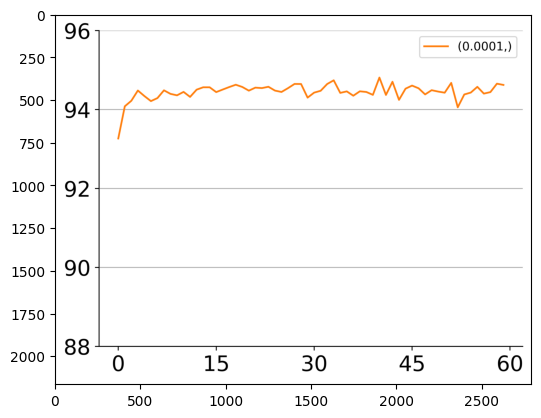

In [34]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/cbp.json', 'accuracy')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 32009.44it/s]


(0.0001,) 0 0.12527777
[array([[0.06666666, 0.        , 0.        , 0.01666667, 0.06666666,
        0.        , 0.08333334, 0.15      , 0.23333332, 0.06666666,
        0.        , 0.05      , 0.05      , 0.05      , 0.25      ,
        0.1       , 0.01666667, 0.05      , 0.28333333, 0.2       ,
        0.18333332, 0.1       , 0.1       , 0.05      , 0.11666666,
        0.1       , 0.1       , 0.03333333, 0.35000002, 0.11666666,
        0.03333333, 0.06666666, 0.08333334, 0.1       , 0.2       ,
        0.1       , 0.06666666, 0.18333332, 0.5       , 0.2       ,
        0.01666667, 0.35000002, 0.11666666, 0.18333332, 0.15      ,
        0.13333333, 0.08333334, 0.2       , 0.31666666, 0.26666665,
        0.06666666, 0.05      , 0.2       , 0.05      , 0.11666666,
        0.06666666, 0.06666666, 0.16666667, 0.15      , 0.25      ]],
      dtype=float32)]


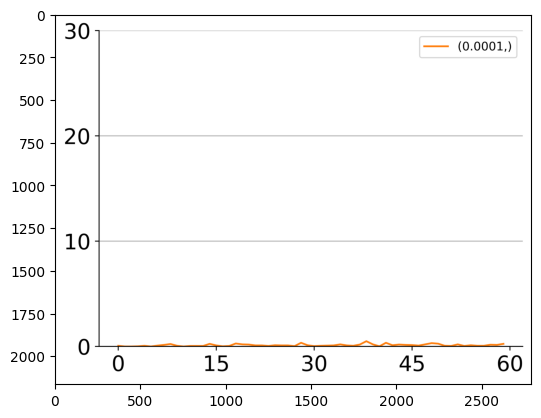

In [35]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/cbp.json', 'dead_neurons')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 17793.84it/s]


(0.0001,) 0 0.0032063478
[array([[0.00452251, 0.00435562, 0.00415594, 0.00388847, 0.00371186,
        0.00354961, 0.00346092, 0.00334872, 0.00327323, 0.0032402 ,
        0.00320573, 0.00314962, 0.00314794, 0.00313853, 0.00313008,
        0.00312713, 0.00309949, 0.00308668, 0.00308854, 0.0030921 ,
        0.00310212, 0.0030924 , 0.00311591, 0.00311031, 0.00310766,
        0.00306962, 0.00307092, 0.00309782, 0.00310996, 0.00309356,
        0.00307495, 0.00308378, 0.00305327, 0.00305779, 0.00306681,
        0.00307525, 0.00309101, 0.00308263, 0.0031106 , 0.00313044,
        0.00312085, 0.00311462, 0.00308947, 0.00311732, 0.00308333,
        0.00305587, 0.00304637, 0.00307832, 0.00308483, 0.00309046,
        0.00307897, 0.00306184, 0.00312291, 0.00312957, 0.00308984,
        0.00308138, 0.00308803, 0.003091  , 0.00309633, 0.00308983]],
      dtype=float32)]


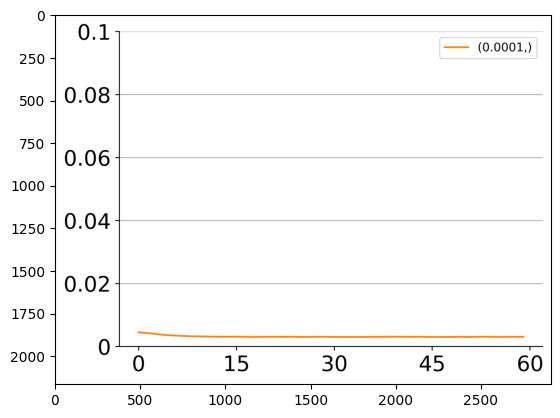

In [36]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/cbp.json', 'weight')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)

100%|██████████| 60/60 [00:00<00:00, 33825.03it/s]


(0.0001,) 0 11.025792
[array([[13.228909 , 13.903353 , 13.789111 , 14.00028  , 12.156336 ,
        13.167421 , 11.611553 , 12.050134 , 10.696997 , 11.436849 ,
        11.117586 , 11.588079 , 11.365762 , 11.160325 , 10.82819  ,
        10.786497 , 11.581319 , 10.959014 , 10.646572 , 10.144387 ,
        10.836737 , 10.732514 , 10.957227 , 11.217427 , 11.050933 ,
        10.77281  , 10.704428 , 11.487237 , 10.694866 , 11.2549305,
        11.059026 , 10.257064 , 11.326586 , 11.141103 , 10.525216 ,
        11.06725  , 10.956077 , 10.505224 ,  9.51794  , 10.480393 ,
        11.095567 , 10.153242 , 10.327689 , 10.189852 , 11.1416235,
        10.249064 , 10.545569 , 10.1287775,  9.745638 , 10.256714 ,
        10.911289 , 10.849284 , 10.212296 , 10.9387045, 10.832528 ,
        10.468986 , 10.454829 , 10.108756 , 10.300892 ,  9.87256  ]],
      dtype=float32)]


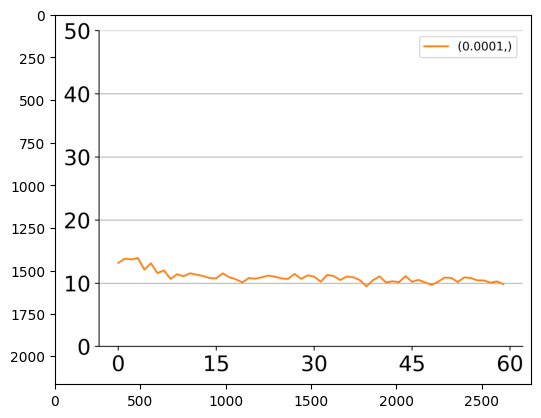

In [37]:
bp_metrics('/kaggle/working/lop/lop/permuted_mnist/cfg/cbp.json', 'effective_rank')
graph = np.asarray(Image.open('comparison.png'))
plt.imshow(graph)